In [23]:
import tensorflow as tf
import numpy as np
import importlib
import pandas as pd
import time
from tensorflow.keras.layers import Resizing, Input, Flatten # type: ignore
import sys, os
import matplotlib.pylab as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..')))

#import dnn_new # type: ignore
import dnn as dnn

#### 1.0 Which Propagation method to choose

Here I test if each of the propagation methods behaves well in training. 
<br>More detailed information regarding each method can be found in ***PropagationMethods.ipynb***

1. [DEPRECIATED] ***RS: via convolution (original code)*** ```method = 'RS_conv_old'```
<br>The method is describes in PropagationMethods.ipynb, in short it is a direct convolution of impulse response of free space and inputs. 
However in this old version all convolutional Kernels are loaded at once. This occupies lots of RAM for the benefit of speed. 
Thus only very physically small systems can be treated correctly.
<br>***There is no reason why we should use this method, it is in here for reference and because it was the original code.***
    - slow
    - mathematically equivalent to 3 
    - super RAM inefficient, basically unusable for physically large systems

2. [DEPRECIATED] ***RS: via convolution (iteratively)*** ```method = 'RS_conv'```
<br> Mathematically just as the method before, however I compute each output pixel intensity one after another. I.E we save lots of RAM compared 1. However this will be slower.
<br>***There is no reason why we should use this method, it is in here for reference and comparison to method 1.***
The Accuracy and results should be an exact match.
    - too slow to be useful
    - mathematically equivalent to 3 

3. ***RS: FFT-Based*** ```method = 'RS_FFT, mode = 0```
<br>Instead of computing the convolution directly we fouriertransform impulse response and input and inverse fouriertransform them back. 
(This approach is based on the convolutional theorem). For implementation I followed: Rayleigh-Sommerfeld (RS) - Shen, F., and Wang, A. (2006). Fast-Fourier-transform based numerical integration method for the Rayleigh-Sommerfeld diffraction formula. Applied Optics, 45(6), 1102–1110. https://doi.org/10.1364/AO.45.001102.
    - fast
    - better for ***small*** D_object/z
    - numerical accuracy improves for smaller delx, dely

4. ***RS: FFT-Based with simson weighing*** ```method = ' 'RS_FFT, mode = 1```
<br>As before but with simsons rule for integration, which shoudl improve accuracy.
This should not impact computational speed or RAM consumption. Only accuracy (not training but propagation) so I will not include it into the testing.

5. ***RS or Angular Spectrum method*** ```method = 'RS_AS, pad = 0'```
<br>Here the impulse response uses the analytical solution for free space propagation in fourierspace. Versus fourier transforming it numerically as in 2-4.
    - fastest (however actually it is similar to 3 & 4 if we adapt the padding), the speedup is solely due to fewer points in FFT (N vs 2N-1)
      if we pad accordingly 3,4 is actually faster
    - better for ***large*** D_object/z
    - numerical accuracy improves with padding


***VERDICT***
<br>The best method for propagation depends on the application, i.e if we propagate large distances and have a small object (3,4) or only propagate a few lambda (5). 
The last method I would only recommend to use with padding.
Possibly a convergence test is useful before training to see which method is more appropriate for the given case.
All methods perform equivalent in training, be aware that differences are due to randomization in trainingsdata (shuffling)

#### 1. Define a model

In [ ]:
importlib.reload(dnn)
from tensorflow.keras.models import Model # type: ignore

#Here I define a little onn
def get_model(x, y, z1, z2, lam, Dmeta , N_Neurons, detector):

    # Get Detector
    input_shape =  (28,28) # size of input images

    # Size of computational domain
    Nx, Ny = (len(x),len(y))

    # Define the Model Layers
    input_layer = Input(shape=input_shape)
    out = tf.transpose(Resizing(Ny, Nx)(tf.transpose(input_layer)))
    out = tf.cast(out, tf.complex64)
    out = dnn.FreeSpacePropagation(x, y, z1, lam)(out) #x, y, lam, N_Neurons, Dx_meta, Dy_meta,
    out = dnn.Meta(x, y, lam, N_Neurons, Dmeta, Dmeta)(out)
    out = dnn.FreeSpacePropagation(x, y, z1, lam)(out)
    out = dnn.Activation.SHG(out)
    out = dnn.FreeSpacePropagation(x, y, z2, lam/2)(out)
    output_layer = dnn.ToDetector(detector)(out)
    
    # Build Model
    model = Model(inputs=input_layer, outputs=output_layer, name="model")


    # Optimize Parameters
    learning_rate = 0.001
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

    # Compile Model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)

    return model

Number of sampling points in computational domain: 56


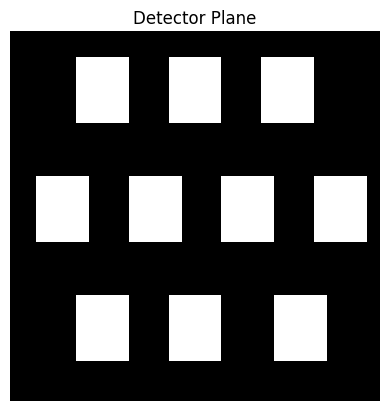

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 28, 28)]          0         Y          
                                                                            
 tf.compat.v1.transpose_2 (  (28, 28, None)            0         Y          
 TFOpLambda)                                                                
                                                                            
 resizing_3 (Resizing)       (56, 56, None)            0         Y          
                                                                            
 tf.compat.v1.transpose_3 (  (None, 56, 56)            0         Y          
 TFOpLambda)                                                                
                                                                            
 tf.cast_1 (TFOpLambda)      (None, 56, 56)            0     

In [25]:
import importlib
importlib.reload(dnn)

### Parameter ###
lam       = 1
z1         = 30*lam  # distance in model between layers (value proofed to perform well in training)
z2         = z1*3  # distance in model between layers (value proofed to perform well in training)
N_Neurons = 28      # number of neurons in metasurface
D         = 28*lam  # same size as metasurface
Dmeta     = D       # lateral size of metasurface
dx        = 0.5*lam # sampling
# Here I set D/2 grid points, as D is in units of lambda this equates to a pixel size of 0.5
x = y = np.linspace(-D/2, D/2, int(D/dx))
print("Number of sampling points in computational domain:",len(x))

### Load Data and detector ###
#   Loads Digit Dataset by default, resize the images inside the model in forward pass (trust me), else it will occupy all your memory
x_train, y_train, x_test, y_test = dnn.loadData() # Trainings and Validation Data

#Load detector and embedds it into compuatational space 
file     = os.path.join(os.getcwd(),'LeoProject/detector_masks',"10_classes_standard.npy")

detector = dnn.loadDetector(D, D, x ,y, file = file)

plt.figure()
plt.imshow(np.sum(detector, axis = 0), cmap = "gray")
plt.axis("off")
plt.title("Detector Plane")
plt.show()

#Loading & Vizualization
model = get_model(x, y, z1, z2, lam, Dmeta , N_Neurons, detector) #Load model
Model.summary(model, expand_nested=True, show_trainable=True) #Display Model

#### 2. Train model

In [22]:
import time
importlib.reload(dnn)
tf.keras.backend.clear_session()

### Train model ###

# Trainigs Parameter
batch_size = 8
epochs     = 1

# Note that AS is not padded so it is expected to be highly inaccurate
# If your metasurfaces are not spaced by large distances AS performs better
# Note that closely spaced metasurfaces are usually not so great for the DNN performance 
# see: https://opg.optica.org/prj/fulltext.cfm?uri=prj-10-11-2667&id=513693: 
# Minjia Zheng, Lei Shi, and Jian Zi, "Optimize performance of a diffractive neural network by controlling the Fresnel number," Photon. Res. 10, 2667-2676 (2022)

#Loading & Vizualization
tf.keras.backend.clear_session()
model = get_model(x, y, z1, z2, lam, Dmeta , N_Neurons, detector) #Load model

# Training
t = time.time()
history_01     = model.fit(x_train, y_train, # obviously you wood need more samples (just for testing)
    batch_size = batch_size,
    shuffle    = True,
    verbose    = 1,
    epochs     = epochs,
    callbacks  = tf.keras.callbacks.EarlyStopping(patience=2),
    validation_data = (x_test, y_test))
print("The training required:\t", time.time()-t, "s")

56 56
1723/7500 [=====>........................] - ETA: 1:23 - loss: 2.0293 - sparse_categorical_accuracy: 0.4502

KeyboardInterrupt: 

(2, 28, 28)


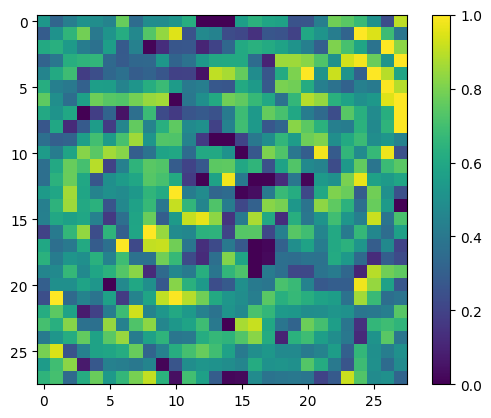

In [14]:
w = model.get_weights()
print(np.shape(w))

plt.imshow(np.array(w[0]))
plt.colorbar()

#### 3. Transfer Weights to new Models

Often You might train a model and save the weights. Here I show how I can set these weights to an untrained model.

You can continue training for that model, test how this model performs for certain classes, vizualize it or change parameters within the new model slightly wrt. 
to the old one to test robustness to inaccuracies in propagation distance, pixel size, phase shifts... whatever you can think of actually.


In [7]:
#Load a new Model
z_new = z + 0.5 #inaccuracy in propagation distance (at every layer of the model)
transfer_model = get_model(x, y, z_new, lam, Dmeta , N_Neurons, detector) 

print("Validation Loss/Accuracy before weights transfer")
transfer_model.evaluate(x_test[:1000], y_test[:1000], batch_size=batch_size)

#Tranfer Weights
w = model.get_weights()
transfer_model.set_weights(w)
    
#Test accuracy again
print("Validation Loss/Accuracy after transfer")
transfer_model.evaluate(x_test[:1000], y_test[:1000], batch_size=batch_size)

NameError: name 'z' is not defined

#### 4. Visualize Layer outputs
Want to have some visual representation of your model?
Most importantly proabably the detection Layer.
Lets have a look!

1/1 [==============================] - 0s 399ms/step


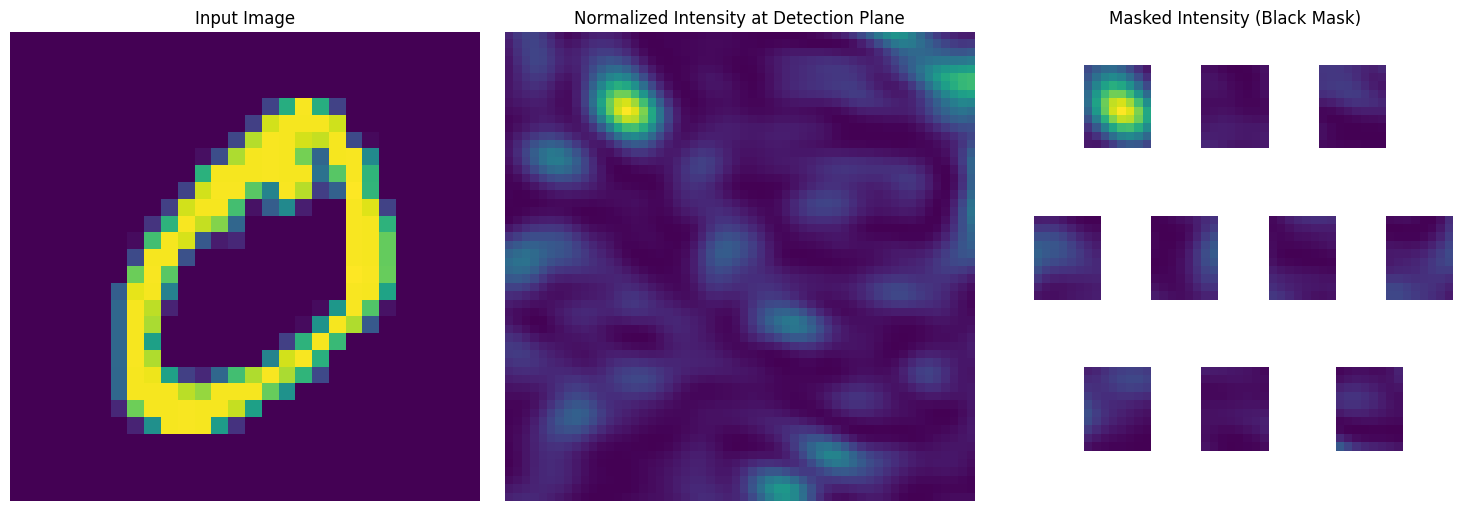

In [19]:
# Pick sample
# Dimensions are expanded because the mdoel expects batches (multiple input images)
sample = np.expand_dims(x_train[1], axis = 0)

# Get Field at detector
layer_output       = model.layers[len(model.layers)-2].output 
intermediate_model = Model(inputs=model.input, outputs=layer_output)  
out                = intermediate_model.predict(sample)
I_detection_plane  = np.abs(np.squeeze(out))**2
I_detection_plane  /=np.max(I_detection_plane)

# Detection mask
mask = np.sum(detector, axis=0)

# Apply mask: set masked regions to NaN
masked_intensity = I_detection_plane.copy()
masked_intensity[mask == 0] = np.nan  # Set regions where mask is zero to NaN

# Define colormap with NaN values appearing as black
cmap = plt.cm.viridis
cmap.set_bad(color="black")

# Plot outputs in a 1x3 layout
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Input image
axes[0].imshow(np.squeeze(sample))
axes[0].axis("off")
axes[0].set_title("Input Image")

# Normalized intensity at detection plane
im1 = axes[1].imshow(I_detection_plane)
axes[1].axis("off")
axes[1].set_title("Normalized Intensity at Detection Plane")


# Masked intensity with NaN regions as black
im2 = axes[2].imshow(masked_intensity)
axes[2].axis("off")
axes[2].set_title("Masked Intensity (Black Mask)")


plt.tight_layout()
plt.show()

#### 5 Help yourself and read the docs

I tried to document my code via docstrings. This is how you can access information without openening the dnn File.

In [76]:
import  inspect

print("List all classes in module")
for name, obj in inspect.getmembers(dnn, inspect.isclass):  
    if obj.__module__ == "dnn":
        print("\t",obj)

print("\nCheck a specific class within module")
print(dnn.FreeSpacePropagation.__doc__)

List all classes in module
	 <class 'dnn.Activation'>
	 <class 'dnn.FreeSpacePropagation'>
	 <class 'dnn.Lens'>
	 <class 'dnn.Meta'>
	 <class 'dnn.ToDetector'>
	 <class 'dnn.embedd2CP'>
	 <class 'dnn.opticalFFT'>

Check a specific class within module

    A class to compute the free space propagation of light.
    Attributes:
        lam(float): wavelength
        x (float[Nx]): meshing of computational domain in x direction
        y (float[Ny]): meshing of computational domain in y direction
        z (float): propagation distance
        Nx (int) : number of meshing points in x-direction
        Ny (int) : number of meshing points in y-direction
        method (string): 'RS_FFT', 'RS_Conv', 'RS_AS', RS_FFT_ver2', RS_conv_old'
        mode : True if you want to apply simson rule to 'RS_FFT' method. False by default.
        pad  : Padding applied in 'RS_AS' method 

    Arguments:
        lam(float): wavelength
        x (float[Nx]): meshing of computational domain in x direction
   